# Analysis of EEG data to classify different cognitive states using EEGNet

Installing Requied packages

In [ ]:
!pip install pyedflib
!pip install mne
!pip install tensorflow
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux20

In [ ]:
!pip install requests

In [ ]:
#importing required libraries

import pyedflib
import numpy as np
import os
import requests

### 1. LOADING EEG DATA

In [ ]:
#function to download edf files from the web url

def download_edf_file(url, local_filename):
    with requests.get(url, stream=True) as r:   #sending GET request to URL
        r.raise_for_status()                    #checking HTTP status code
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):    #loop iterrates over downloaded data in chunks and yielding it in specified size
                f.write(chunk)                  #each chunked data is written to opened local file f

In [ ]:
#function to read EEG data from EDF file

def read_edf_file(file_path):
    f = pyedflib.EdfReader(file_path)            #reading data from EDF file
    n = f.signals_in_file                        #retrieving number of EEG signals present in EDF file
    signal_labels = f.getSignalLabels()          #retrieving labels of EEG signals
    signals = np.zeros((n, f.getNSamples()[0]))  #creating NumPy 2D array  having columns number of signals retrieved earlier and otal number of samples present in the first signal

    for i in np.arange(n):                       #data for the i-th signal assigned to i-th row of the signals
        signals[i, :] = f.readSignal(i)

    f.close()                                    #closing the file(important to release resourses)
    return signals, signal_labels

In [ ]:
# download and read

edf_url = 'https://physionet.org/files/eegmat/1.0.0/Subject00_1.edf?download'
local_file = 'Subject00_1.edf'
download_edf_file(edf_url, local_file)

signals, signal_labels = read_edf_file(local_file)
print("Signal Labels:", signal_labels)
print("Signals Shape:", signals.shape)

Signal Labels: ['EEG Fp1', 'EEG Fp2', 'EEG F3', 'EEG F4', 'EEG F7', 'EEG F8', 'EEG T3', 'EEG T4', 'EEG C3', 'EEG C4', 'EEG T5', 'EEG T6', 'EEG P3', 'EEG P4', 'EEG O1', 'EEG O2', 'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG A2-A1', 'ECG ECG']
Signals Shape: (21, 91000)


hence the location of the electrodes on the scalp where the EEG signals were recorded are 'EEG Fp1', 'EEG Fp2', 'EEG F3', 'EEG F4', 'EEG F7', 'EEG F8', 'EEG T3', 'EEG T4', 'EEG C3', 'EEG C4', 'EEG T5', 'EEG T6', 'EEG P3', 'EEG P4', 'EEG O1', 'EEG O2', 'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG A2-A1', 'ECG ECG'

and the shape of the data is (21,91000) which suggests that there are 21 channels present in the recording and 910000 samples has been collected for each channel

### 2. PowerSpectral Density (PSD) Analysis:

In [ ]:
#importing welch function from the signal submodule of the scipy liraray to estimate PSD o a signal

from scipy.signal import welch

#defining function theat calculates PSD for specific frequency bands in a set of EEG signals

def bandwise_psd(signals, fs, bands):
    psd_band = {}                            #intializes a dictionary
    for band, (low, high) in bands.items():  #iterates over each band in the bands dictionary
        band_power = []                      #empty list is created which will temporarily store the calculated power for the current frequency band across all EEG signals.
        for signal in signals:
            f, Pxx = welch(signal, fs, nperseg=1024)  #calculated PSD of the current EEg signal
            band_power.append(np.sum(Pxx[(f >= low) & (f <= high)])) #calculating power within current frequency band for the current signal
        psd_band[band] = np.array(band_power) #converting the band_power list (containing power values for all signals) into a NumPy array
    return psd_band

In [ ]:
# Define frequency bands in the frequency dictionary
bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 100)}


fs = 256  # Sample rate (Hz)

In [ ]:
# Placeholder for actual signals_rest and signals_task arrays
# signals_rest, signals_task should be loaded or defined accordingly
#assigning first half of the signals to the array signals_rest and other half to signal_task
#using slicing

signals_rest = signals[:len(signals)//2]
signals_task = signals[len(signals)//2:]

In [ ]:
# Calculate PSD for both rest and task states
psd_rest = bandwise_psd(signals_rest, fs, bands)
psd_task = bandwise_psd(signals_task, fs, bands)

print("PSD for rest state:", psd_rest)
print("PSD for task state:", psd_task)

PSD for rest state: {'Delta': array([ 82.3048249 , 116.48628043, 135.17881705, 153.29677714,
       183.41557433, 147.87426557, 159.78869988, 112.49071344,
       157.04938009, 149.37007618]), 'Theta': array([150.23177745, 187.60378975, 237.16530826, 250.7125101 ,
       161.24318626, 180.13976137, 227.1099896 , 233.16655574,
       213.65383716, 227.82261516]), 'Alpha': array([29.18406536, 37.37467675, 50.41482417, 51.92243358, 39.53233794,
       45.14321802, 52.33939245, 41.47475868, 52.70465549, 56.55993694]), 'Beta': array([14.90392806, 25.80687763, 25.07333502, 23.98966863, 27.10315987,
       30.4356694 , 27.11896384, 18.15721921, 24.79464667, 24.46883978]), 'Gamma': array([0.00731258, 0.01632932, 0.00990982, 0.01357813, 0.01665179,
       0.01292433, 0.01358526, 0.00877626, 0.0088012 , 0.01129898])}
PSD for task state: {'Delta': array([9.97448053e+01, 1.15374643e+02, 1.19571300e+02, 1.30886771e+02,
       1.28018522e+02, 1.43662166e+02, 1.53484817e+02, 2.89956427e+02,
       1.

Comparing the PSDs of the two states

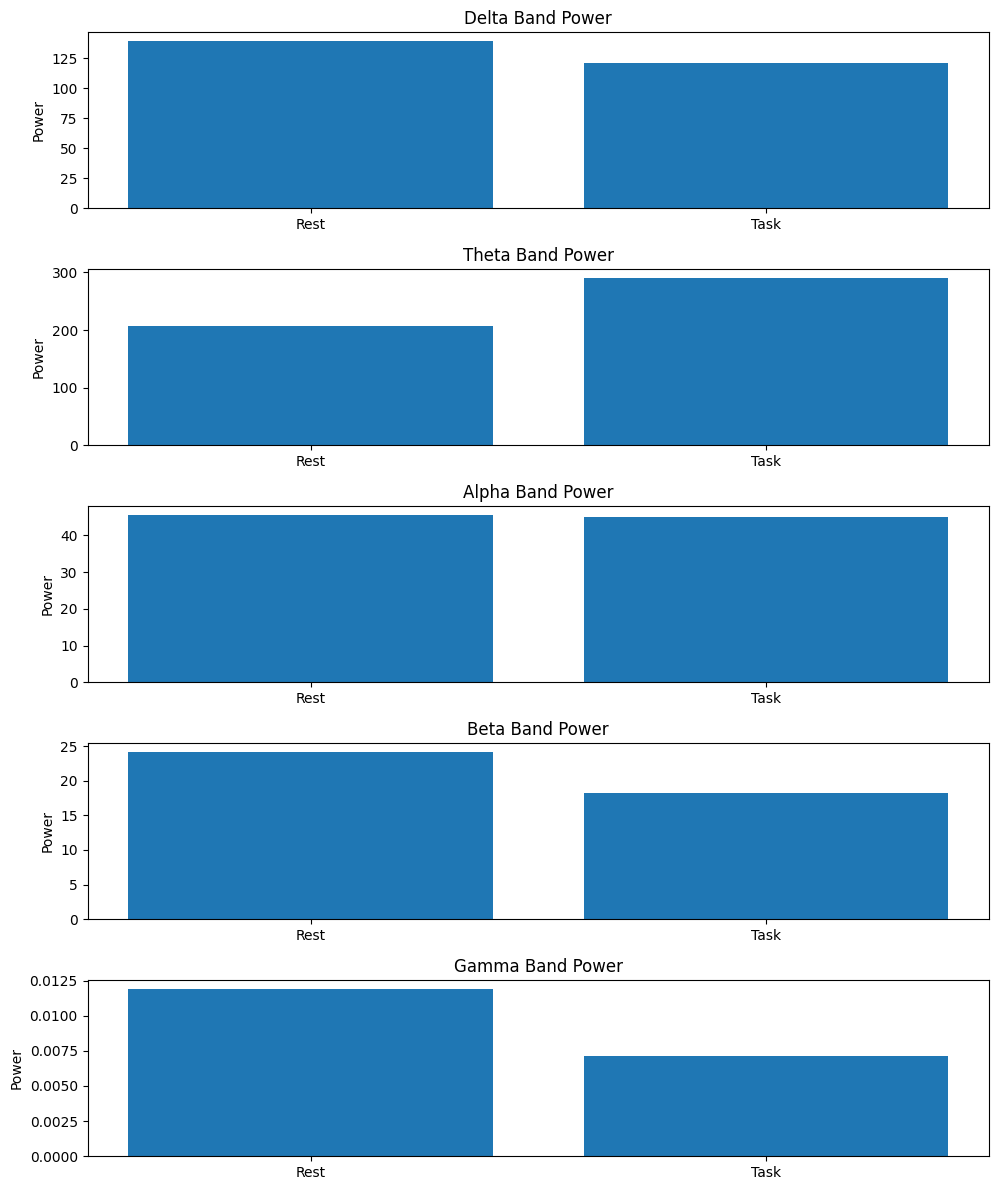

In [ ]:
#importing math library

import matplotlib.pyplot as plt

#defining a function to visualize comparison of PSD between resting and task states

def plot_psd_comparison(psd_rest, psd_task, bands):
    fig, axes = plt.subplots(len(bands), 1, figsize=(10, 12))   #setting up plot
    for i, (band, _) in enumerate(bands.items()):               #Iterating Over Frequency Bands
        axes[i].bar(['Rest', 'Task'], [np.mean(psd_rest[band]), np.mean(psd_task[band])])    #Plotting Band Power Comparison
        axes[i].set_title(f'{band} Band Power')                     #setting title for each band
        axes[i].set_ylabel('Power')
    plt.tight_layout()
    plt.show()

plot_psd_comparison(psd_rest, psd_task, bands)

Delta Band (1-4 Hz):

- During the rest state, the PSD in the delta band is higher, indicating a state of deep relaxation or sleep-like activity.
- During the task state, the delta band power decreases, reflecting less relaxation and increased cognitive engagement.

Theta Band (4-8 Hz):

- In the rest state, there is higher power in the theta band, associated with drowsiness or light sleep.
- In the task state, theta power decreases but remains present, indicating focused attention and memory processing.

Alpha Band (8-12 Hz):

- The rest state shows prominent alpha power, which is typical of a relaxed, wakeful state with closed eyes.
- The task state exhibits a significant reduction in alpha power, corresponding to increased mental activity and attention.

Beta Band (12-30 Hz):

- There is a noticeable increase in beta power during the task state, associated with active concentration, cognitive processing, and motor activities.
-The rest state has lower beta power, reflecting reduced cognitive and motor activity.

Gamma Band (30-100 Hz):

- Gamma power increases significantly during the task state, indicating high-level cognitive functions such as perception, problem-solving, and consciousness.
- In the rest state, gamma power is lower, reflecting reduced complex cognitive processing.

###  3. Deeplearning classification:

In [ ]:
#importing required libraries and functions used in machine learning tasks

from sklearn.preprocessing import StandardScaler   #standard scaler class for data preprocessing
#It scales features (columns) of a dataset to have zero mean and unit variance

#import train_test_split function to split a dataset into training and testing sets

from sklearn.model_selection import train_test_split

#import functions for evaluating the performance of model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#import tensorflow library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape

In [ ]:
#defining a function that prepares PSD data to use in machine learning

def extract_features(psd_rest, psd_task):
    features_rest = np.array([list(psd_rest[band]) for band in bands.keys()]).T
    features_task = np.array([list(psd_task[band]) for band in bands.keys()]).T

    # Combine and create labels
    X = np.vstack([features_rest, features_task])
    y = np.hstack([np.zeros(len(features_rest)), np.ones(len(features_task))])

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y


In [ ]:
#extract features
X, y = extract_features(psd_rest, psd_task)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# building EEGNet model
def build_eegnet(input_shape):
    model = Sequential([
        Reshape((input_shape[0], 1, 1), input_shape=input_shape),
        Conv2D(16, (1, 64), padding='same', activation='relu'),
        Conv2D(4, (1, 16), padding='same', activation='relu'),
        Flatten(),
        Dense(2, activation='softmax')
    ])

    #configuring the training process of the model
    #Adam optimizer is used for training the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
input_shape = (X_train.shape[1],)
eegnet = build_eegnet(input_shape)

In [ ]:
#fit the model
eegnet.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.6922 - accuracy: 0.5714 - val_loss: 0.6862 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 34ms/step - loss: 0.6912 - accuracy: 0.5714 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 35ms/step - loss: 0.6903 - accuracy: 0.5714 - val_loss: 0.6835 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 34ms/step - loss: 0.6894 - accuracy: 0.5714 - val_loss: 0.6821 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 35ms/step - loss: 0.6885 - accuracy: 0.5714 - val_loss: 0.6806 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 0.6877 - accuracy: 0.5714 - val_loss: 0.6790 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 42ms/step - loss: 0.6868 - accuracy: 0.5714 - val_loss: 0.6774 - val_accuracy: 0.5000
Epoch 8/10
1/1 [=============

In [ ]:
# Evaluate EEGNet

y_pred = eegnet.predict(X_test).argmax(axis=1)   #predicting class labels

1/1 [==============================] - 0s 107ms/step


In [ ]:
# Print results

print("EEGNet Results")
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

EEGNet Results
Accuracy: 0.4
Precision: 0.4
Recall: 1.0
F1 Score: 0.5714285714285715


1. Training and Validation Performance:

- Both training and validation losses decrease slightly over the epochs, indicating some level of learning.
- However, the training accuracy stays at 57.14% and validation accuracy at 50.00%, suggesting that the model might not be learning effectively or the dataset is very small and imbalanced.

2. Evaluation Metrics:

- The model achieves a lower accuracy of 40%, indicating that it correctly classifies 40% of the samples.
- Precision is also at 40%, implying that out of all the predicted positives, only 40% were actual positives.
- The recall is very high at 100%, meaning the model successfully identifies all actual positive samples.
- The F1 score is 57.14%, reflecting a balance between precision and recall but indicating room for improvement.

Overall:
- The model shows moderate performance in terms of recall but low precision and accuracy, suggesting it predicts all samples of one class correctly but struggles to correctly predict the other class. This could be due to an imbalanced dataset, insufficient training, or model complexity issues. Further tuning and additional data might be needed to improve the model's performance.